In [32]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os
from tqdm import tqdm

In [33]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    features = {
        'spectral_centroid': librosa.feature.spectral_centroid(y=y, sr=sr),
        'spectral_contrast': librosa.feature.spectral_contrast(y=y, sr=sr),
        'chroma': librosa.feature.chroma_stft(y=y, sr=sr),
        'sr': sr,
        # 'tempo': librosa.feature.rhythm.tempo(y=y, sr=sr)[0]
    }
    return features

In [34]:
features_ground_truth = extract_features("/data/tilak/projects/music-diffusion/samples/ground_truth/2E-xax1gq7M_10_40.wav")
features_generated = extract_features("/data/tilak/projects/music-diffusion/samples/generated/2E-xax1gq7M_10_40.wav")
features_generated_audioldm = extract_features("/data/tilak/projects/music-diffusion/samples/audioldm_generated/2E-xax1gq7M_10_40.wav")

In [35]:
import numpy as np

def normalize_spectral_centroids(spectral_centroids):
    """
    Normalize spectral centroids.

    Parameters:
    - spectral_centroids: Array of spectral centroids.

    Returns:
    - Normalized spectral centroids.
    """
    return (spectral_centroids - spectral_centroids.min()) / (spectral_centroids.max() - spectral_centroids.min())


In [36]:
def calculate_mae(actual, predicted):
    """
    Calculate the mean absolute error between two arrays.

    Parameters:
    - actual: Array of actual values.
    - predicted: Array of predicted values.

    Returns:
    - MAE: The mean absolute error.
    """
    return np.mean(np.abs(actual - predicted))

def calculate_rmse(actual, predicted):
    """
    Calculate the root mean square error between two arrays.

    Parameters:
    - actual: Array of actual values.
    - predicted: Array of predicted values.

    Returns:
    - RMSE: The root mean square error.
    """
    return np.sqrt(np.mean((actual - predicted) ** 2))


In [37]:
import matplotlib.pyplot as plt
import librosa

def plot_spectral_centroids(times_gt, sc_gt_norm, times_gen, sc_gen_norm, times_audioldm, sc_audioldm_norm):
    """
    Plot normalized spectral centroids over time for ground truth, generated, and AudioLDM generated samples.

    Parameters:
    - times_gt: Time array for ground truth.
    - sc_gt_norm: Normalized spectral centroid for ground truth.
    - times_gen: Time array for generated sample.
    - sc_gen_norm: Normalized spectral centroid for generated sample.
    - times_audioldm: Time array for AudioLDM generated sample.
    - sc_audioldm_norm: Normalized spectral centroid for AudioLDM generated sample.
    """
    plt.figure(figsize=(12, 8))
    plt.plot(times_gt, sc_gt_norm, color='r', label='Ground Truth')
    plt.plot(times_gen, sc_gen_norm, color='g', label='Generated')
    plt.plot(times_audioldm, sc_audioldm_norm, color='b', label='AudioLDM Generated')
    plt.title('Normalized Spectral Centroids over Time')
    plt.legend(loc='upper right')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Spectral Centroid')
    plt.show()

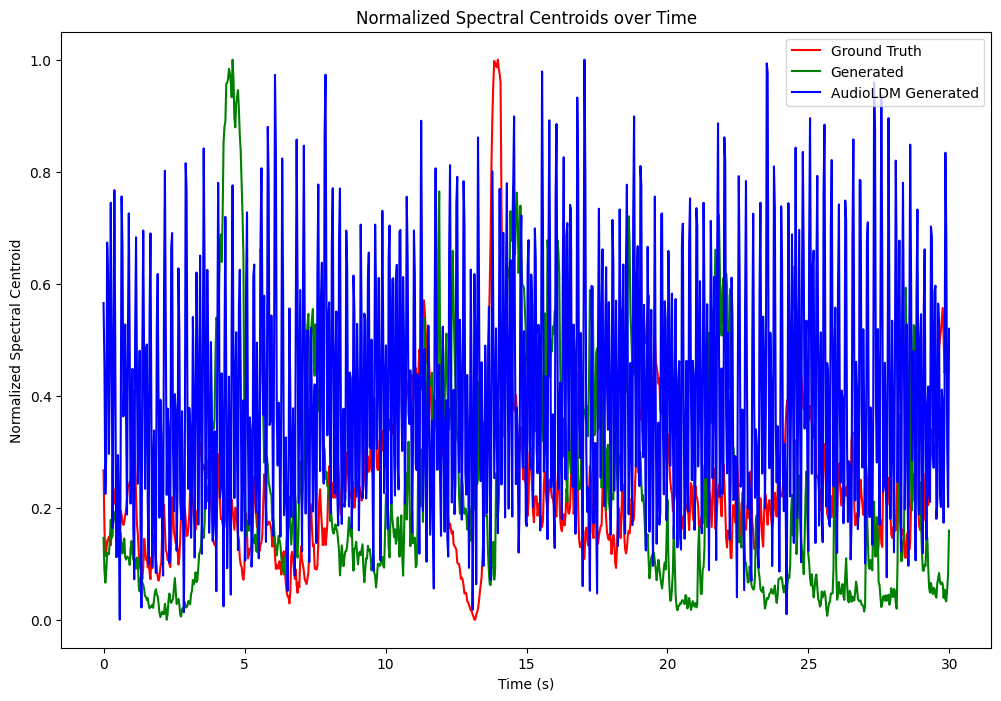

0.20139393159427563
0.23737604274042834
0.25543510031528444
0.30375056442188886


In [38]:
sc_gt = features_ground_truth['spectral_centroid']
sc_gen = features_generated['spectral_centroid']
sc_audioldm = features_generated_audioldm['spectral_centroid']

sr = features_generated_audioldm['sr']

sc_gt_norm = (sc_gt - sc_gt.min()) / (sc_gt.max() - sc_gt.min())
sc_gen_norm = (sc_gen - sc_gen.min()) / (sc_gen.max() - sc_gen.min())
sc_audioldm_norm = (sc_audioldm - sc_audioldm.min()) / (sc_audioldm.max() - sc_audioldm.min())

min_len = min(len(sc_gen_norm[0]), len(sc_gt_norm[0]), len(sc_audioldm_norm[0]))
sc_gt_norm = sc_gt_norm.T[:min_len]
sc_gen_norm = sc_gen_norm.T[:min_len]
sc_audioldm_norm = sc_audioldm_norm.T[:min_len]

times_gt = librosa.frames_to_time(np.arange(sc_gt_norm.shape[0]), sr=sr)
times_gen = librosa.frames_to_time(np.arange(sc_gen_norm.shape[0]), sr=sr)
times_audioldm = librosa.frames_to_time(np.arange(sc_audioldm_norm.shape[0]), sr=sr)

plot_spectral_centroids(times_gt=times_gt, sc_gt_norm=sc_gt_norm, 
times_gen=times_gen, sc_gen_norm=sc_gen_norm, 
times_audioldm=times_audioldm, sc_audioldm_norm=sc_audioldm_norm)

print(calculate_mae(sc_gt_norm, sc_gen_norm))
print(calculate_mae(sc_gt_norm, sc_audioldm_norm))
print(calculate_rmse(sc_gt_norm, sc_gen_norm))
print(calculate_rmse(sc_gt_norm, sc_audioldm_norm))

In [39]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

class AudioFeatureAnalyzer:
    def __init__(self, file_paths):
        self.features = {}
        self.extract_features(file_paths)
        
    def extract_features(self, file_paths):
        for key, file_path in file_paths.items():
            y, sr = librosa.load(file_path, sr=16000)
            self.features[key] = {
                'spectral_centroid': librosa.feature.spectral_centroid(y=y, sr=sr),
                'spectral_contrast': librosa.feature.spectral_contrast(y=y, sr=sr),
                'chroma': librosa.feature.chroma_stft(y=y, sr=sr),
                'sr': sr,
            }
    
    def normalize_feature(self, feature_key):
        # Determine minimum length for the feature across all files
        min_len = min([self.features[key][feature_key].shape[1] for key in self.features.keys()])
        
        # Normalize and slice the features to the minimum length
        for key in self.features.keys():
            feature = self.features[key][feature_key][:, :min_len]  # Slice before normalizing
            normalized = (feature - feature.min()) / (feature.max() - feature.min())
            self.features[key][feature_key + '_normalized'] = normalized
    
    def calculate_mae(self, feature_key, reference_key='ground_truth'):
        actual = self.features[reference_key][feature_key + '_normalized']
        results = {}
        for key in self.features:
            if key != reference_key:
                predicted = self.features[key][feature_key + '_normalized']
                mae = np.mean(np.abs(actual - predicted))
                results[key] = mae
        return results
    
    def calculate_rmse(self, feature_key, reference_key='ground_truth'):
        actual = self.features[reference_key][feature_key + '_normalized']
        results = {}
        for key in self.features:
            if key != reference_key:
                predicted = self.features[key][feature_key + '_normalized']
                rmse = np.sqrt(np.mean((actual - predicted) ** 2))
                results[key] = rmse
        return results
    
    def plot_features(self, feature_key, reference_key='ground_truth', log_scale=False, start_sec=0, end_sec=30):
        sr = self.features[reference_key]['sr']
        plt.figure(figsize=(12, 8))
        
        # Determine minimum length for plotting
        min_len = min([self.features[key][feature_key + '_normalized'].shape[1] for key in self.features.keys()])

        colors = {
            'ground_truth': 'r',
            'pixmus_generated': 'g',
            'audioldm_generated': 'b'
        }
        
        for key, features in self.features.items():
            feature = features[feature_key + '_normalized'][:, :min_len]  # Ensure slicing is done
            times = librosa.frames_to_time(np.arange(min_len), sr=sr)
            values_per_sec = len(times)//30
            slice_start = values_per_sec * start_sec
            slice_end = values_per_sec * end_sec
            plt.plot(times[slice_start:slice_end], feature.mean(axis=0)[slice_start:slice_end], label=key, color=colors.get(key, 'k'))
            
        plt.title(f'Normalized {feature_key} over Time')
        plt.legend(loc='upper right')
        plt.xlabel('Time (s)')
        plt.ylabel(f'Normalized {feature_key}')

        if log_scale:
            plt.yscale('log')

        plt.show()

In [40]:
file_paths = {
    'ground_truth': "/data/tilak/projects/music-diffusion/samples/ground_truth/2E-xax1gq7M_10_40.wav",
    'pixmus_generated': "/data/tilak/projects/music-diffusion/samples/generated/2E-xax1gq7M_10_40.wav",
    'audioldm_generated': "/data/tilak/projects/music-diffusion/samples/audioldm_generated/2E-xax1gq7M_10_40.wav"
}

analyzer = AudioFeatureAnalyzer(file_paths)

analyzer.normalize_feature('spectral_centroid')
analyzer.normalize_feature('spectral_contrast')
analyzer.normalize_feature('chroma')


{'pixmus_generated': 0.20139393159427563, 'audioldm_generated': 0.23737604274042834}
{'pixmus_generated': 0.25543510031528444, 'audioldm_generated': 0.30375056442188886}


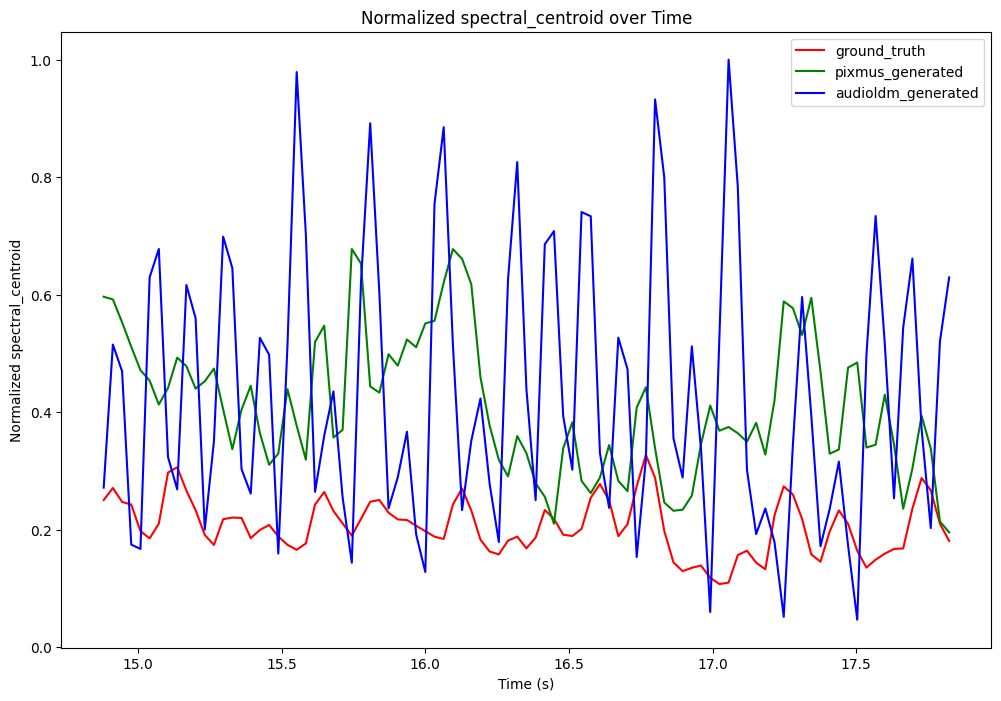

In [41]:
print(analyzer.calculate_mae('spectral_centroid'))
print(analyzer.calculate_rmse('spectral_centroid'))

# Plot features
analyzer.plot_features('spectral_centroid', start_sec=15, end_sec=18)

{'pixmus_generated': 0.09170785368726313, 'audioldm_generated': 0.09958668819866341}
{'pixmus_generated': 0.11877929842165368, 'audioldm_generated': 0.1349303696084712}


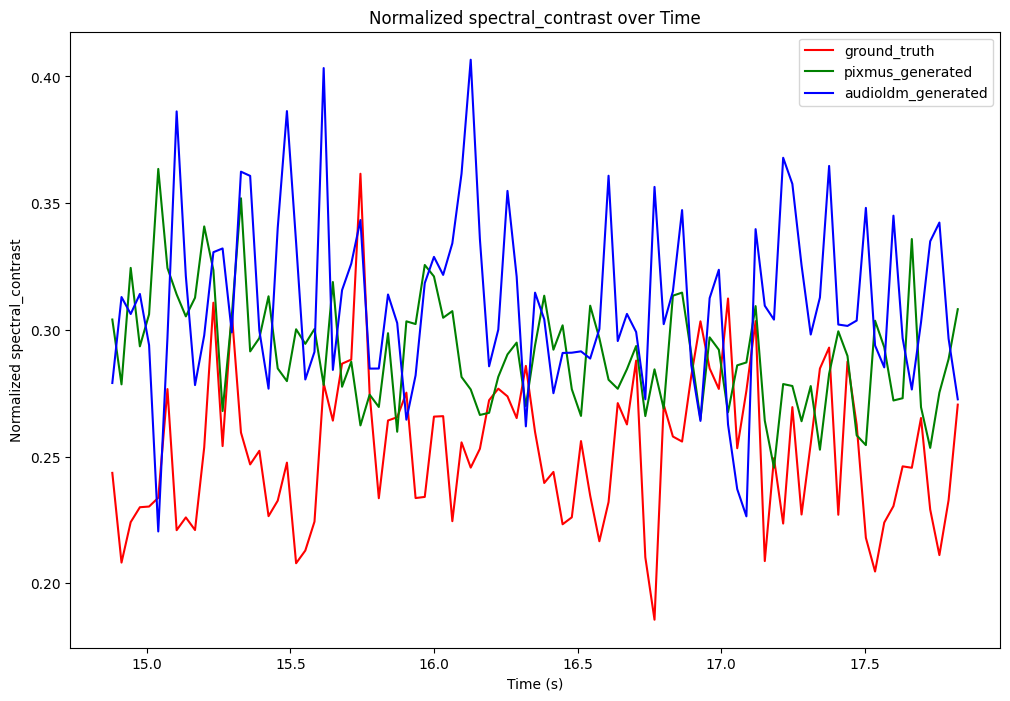

In [42]:
print(analyzer.calculate_mae('spectral_contrast'))
print(analyzer.calculate_rmse('spectral_contrast'))

# Plot features
analyzer.plot_features('spectral_contrast', start_sec=15, end_sec=18)

{'pixmus_generated': 0.31816843, 'audioldm_generated': 0.36478367}
{'pixmus_generated': 0.40410563, 'audioldm_generated': 0.4506534}


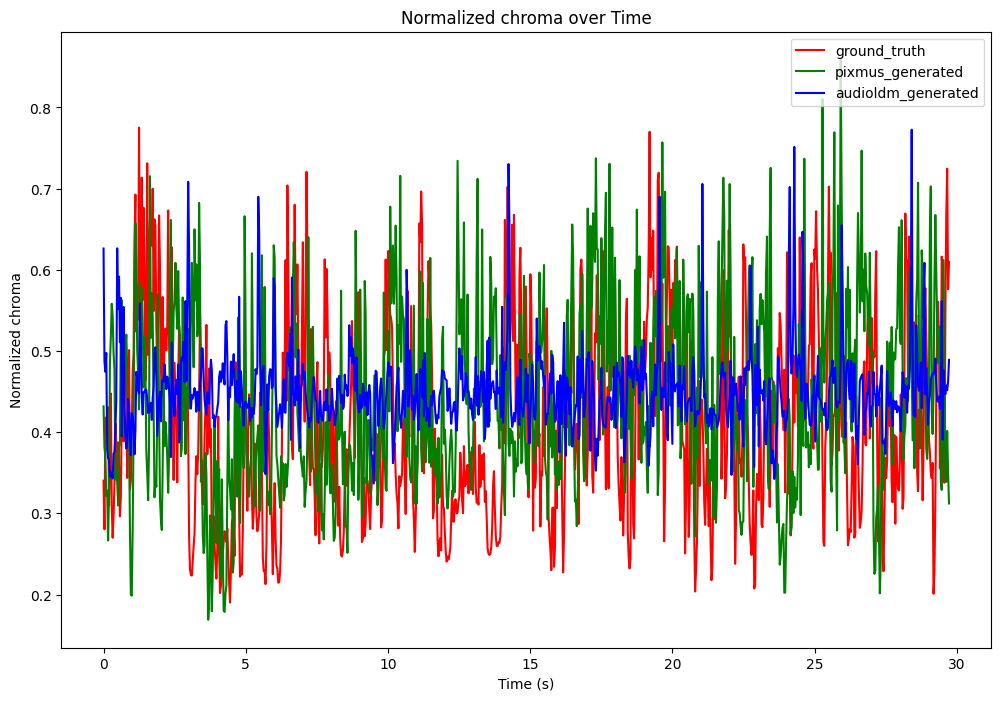

In [45]:
print(analyzer.calculate_mae('chroma'))
print(analyzer.calculate_rmse('chroma'))

# Plot features
analyzer.plot_features('chroma')

In [44]:
GROUND_TRUTH_DIR = '/data/tilak/projects/music-diffusion/samples/ground_truth'

In [28]:
spectral_centroid_maes = []
spectral_contrast_maes = []
spectral_chroma_maes = []

spectral_centroid_rmse = []
spectral_contrast_rmse = []
spectral_chroma_rmse = []

for gt in tqdm(os.listdir(GROUND_TRUTH_DIR)):
    file_paths = {
        'ground_truth': f"/data/tilak/projects/music-diffusion/samples/ground_truth/{gt}",
        'generated': f"/data/tilak/projects/music-diffusion/samples/generated/{gt}",
        'audioldm_generated': f"/data/tilak/projects/music-diffusion/samples/audioldm_generated/{gt}"
    }

    analyzer = AudioFeatureAnalyzer(file_paths)

    analyzer.normalize_feature('spectral_centroid')
    analyzer.normalize_feature('spectral_contrast')
    analyzer.normalize_feature('chroma')

    spectral_centroid_maes.append(analyzer.calculate_mae('spectral_centroid'))
    spectral_contrast_maes.append(analyzer.calculate_mae('spectral_contrast'))
    spectral_chroma_maes.append(analyzer.calculate_mae('chroma'))

    spectral_centroid_rmse.append(analyzer.calculate_rmse('spectral_centroid'))
    spectral_contrast_rmse.append(analyzer.calculate_rmse('spectral_contrast'))
    spectral_chroma_rmse.append(analyzer.calculate_rmse('chroma'))
        

100%|██████████| 481/481 [02:43<00:00,  2.95it/s]


In [29]:
mean_generated_sc = sum(item['generated'] for item in spectral_centroid_maes) / len(spectral_centroid_maes)
mean_audioldm_generated_sc = sum(item['audioldm_generated'] for item in spectral_centroid_maes) / len(spectral_centroid_maes)

mean_generated_contrast = sum(item['generated'] for item in spectral_contrast_maes) / len(spectral_contrast_maes)
mean_audioldm_generated_contrast = sum(item['audioldm_generated'] for item in spectral_contrast_maes) / len(spectral_contrast_maes)

mean_generated_chroma = sum(item['generated'] for item in spectral_chroma_maes) / len(spectral_chroma_maes)
mean_audioldm_generated_chroma = sum(item['audioldm_generated'] for item in spectral_chroma_maes) / len(spectral_chroma_maes)

mean_generated_sc_rmse = sum(item['generated'] for item in spectral_centroid_rmse) / len(spectral_centroid_rmse)
mean_audioldm_generated_sc_rmse = sum(item['audioldm_generated'] for item in spectral_centroid_rmse) / len(spectral_centroid_rmse)

mean_generated_contrast_rmse = sum(item['generated'] for item in spectral_contrast_rmse) / len(spectral_contrast_rmse)
mean_audioldm_generated_contrast_rmse = sum(item['audioldm_generated'] for item in spectral_contrast_rmse) / len(spectral_contrast_rmse)

mean_generated_chroma_rmse = sum(item['generated'] for item in spectral_chroma_rmse) / len(spectral_chroma_rmse)
mean_audioldm_generated_chroma_rmse = sum(item['audioldm_generated'] for item in spectral_chroma_rmse) / len(spectral_chroma_rmse)

In [30]:
print("Mean MAE for Spectral Centroid:")
print("Generated:", mean_generated_sc)
print("AudioLDM Generated:", mean_audioldm_generated_sc)

print("\nMean MAE for Spectral Contrast:")
print("Generated:", mean_generated_contrast)
print("AudioLDM Generated:", mean_audioldm_generated_contrast)

print("\nMean MAE for Chroma:")
print("Generated:", mean_generated_chroma)
print("AudioLDM Generated:", mean_audioldm_generated_chroma)

print("\nMean RMSE for Spectral Centroid:")
print("Generated:", mean_generated_sc_rmse)
print("AudioLDM Generated:", mean_audioldm_generated_sc_rmse)

print("\nMean RMSE for Spectral Contrast:")
print("Generated:", mean_generated_contrast_rmse)
print("AudioLDM Generated:", mean_audioldm_generated_contrast_rmse)

print("\nMean RMSE for Chroma:")
print("Generated:", mean_generated_chroma_rmse)
print("AudioLDM Generated:", mean_audioldm_generated_chroma_rmse)

Mean MAE for Spectral Centroid:
Generated: 0.21709905418721862
AudioLDM Generated: 0.22523797195820955

Mean MAE for Spectral Contrast:
Generated: 0.11485308223351252
AudioLDM Generated: 0.11545379521761136

Mean MAE for Chroma:
Generated: 0.28762977354987496
AudioLDM Generated: 0.3247808051022571

Mean RMSE for Spectral Centroid:
Generated: 0.26921477868080135
AudioLDM Generated: 0.2750334093909272

Mean RMSE for Spectral Contrast:
Generated: 0.14639150022303923
AudioLDM Generated: 0.14587070670554075

Mean RMSE for Chroma:
Generated: 0.3902589272002916
AudioLDM Generated: 0.41466375020586277


## Spectogram

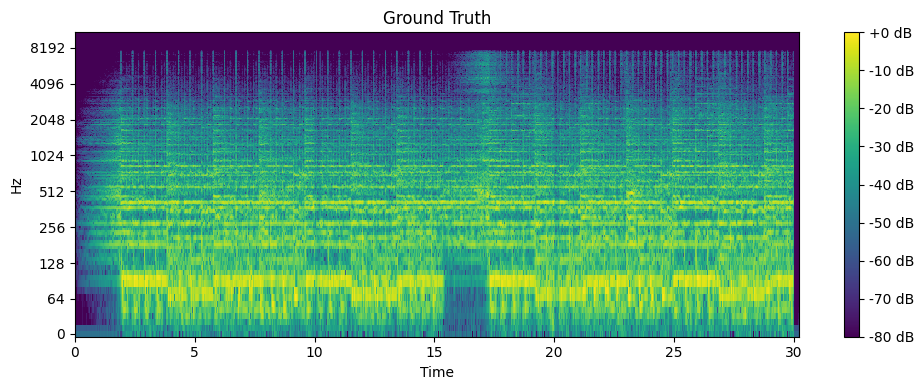

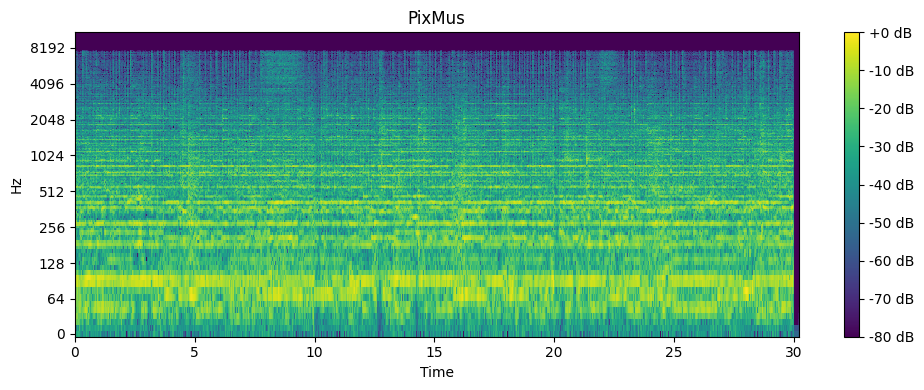

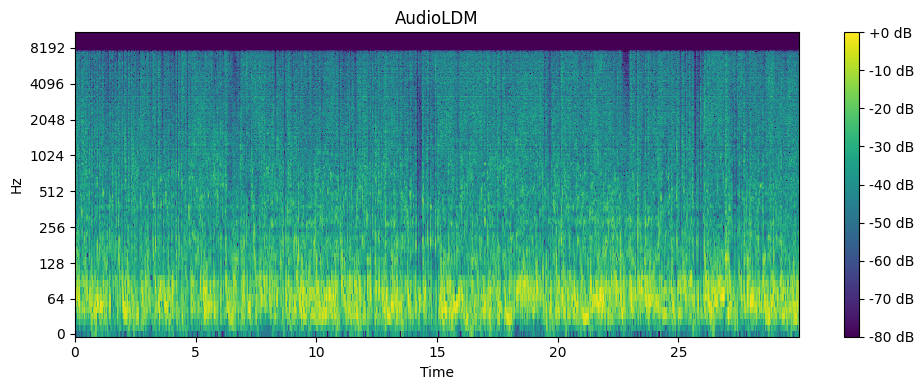

In [6]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram(audio_path, title='Spectrogram', cmap='viridis'):
    # Load audio file
    y, sr = librosa.load(audio_path)
    # Compute the spectrogram magnitude and phase
    S_complex = librosa.stft(y)
    S, phase = librosa.magphase(S_complex)
    # Convert to log scale (dB)
    S_dB = librosa.amplitude_to_db(S, ref=np.max)

    # Plot
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log', cmap=cmap)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Paths to your audio files
audio_files = [
    '/data/tilak/projects/music-diffusion/samples/ground_truth/jaW4o2zI-e4_0_30.wav',
    '/data/tilak/projects/music-diffusion/samples/generated/jaW4o2zI-e4_0_30.wav',
    '/data/tilak/projects/music-diffusion/samples/audioldm_generated/jaW4o2zI-e4_0_30.wav'
]

titles = ['Ground Truth', 'PixMus', 'AudioLDM']

# Generate and display spectrogram for each audio file
for i, file in enumerate(audio_files):
    plot_spectrogram(file, title=f'{titles[i]}')

## Resnet18

In [10]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Remove the final fully connected layer to get the feature extractor
model = nn.Sequential(*list(model.children())[:-1])

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet image size requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Function to load an image, preprocess it, and extract features
def extract_features(img_path, model, transform):
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img)
    img_t = img_t.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():  # No need to track gradients
        features = model(img_t)
    return features.squeeze().numpy()  # Convert to numpy array

# Paths to your spectrogram images
spectrogram1_path = '/data/tilak/projects/music-diffusion/plots/gt_stft.png'
spectrogram2_path = '/data/tilak/projects/music-diffusion/plots/pixmus_stft.png'

# Extract features
features1 = extract_features(spectrogram1_path, model, transform)
features2 = extract_features(spectrogram2_path, model, transform)

# Calculate cosine similarity
cosine_similarity = torch.nn.CosineSimilarity(dim=0)
similarity = cosine_similarity(torch.tensor(features1), torch.tensor(features2))
print(f'Similarity between the two spectrograms: {similarity.item()}')

Similarity between the two spectrograms: 0.9702923893928528
